In [1]:
import sqlalchemy as sq
import pymysql

import pandas as pd
import numpy as np

import os
import csv

import datetime as dt

sq.__version__

'1.0.13'

In [2]:

def convert_unixtime(stamp):
    return dt.datetime.fromtimestamp(
        int(stamp)
    ).strftime('%Y-%m-%d')

In [3]:
# Set hash function to anonymize data
import hashlib

SALT = os.urandom(16)

def anonymize(value):
    return hashlib.sha1(value+SALT).hexdigest()

In [4]:
def find_dept(email):
    ampersand = email.find('@')
    tail = email[ampersand + 1:]
    try:
        return dept_dict[tail]
    except KeyError:
        return "OTHER"

## Set up Dept List/Dict

In [5]:
dept_dict = {}

data_path = r'/Users/toferc/Documents/Data/'
output_path = r'/Users/toferc/Documents/Report Card/April/'

In [6]:
with open(os.path.join(data_path, 'csv_keys.csv'), "r") as f:
    reader = csv.reader(f, delimiter=',')
    next(reader)
    
    for row in reader:
        email, acronym = row
        dept_dict[email] = acronym

dept_dict['cadets.gc.ca'] = 'CADETS'
dept_dict['canada.gc.ca'] = 'CANADA'
dept_dict['canada.ca'] = 'CANADA'
dept_dict['tribunal.gc.ca'] = 'TRIBUNAL'
dept_dict['cannor.gc.ca'] = 'CED/DEC'
dept_dict['ci-oic.gc.ca'] = 'CI/OIC'
dept_dict['ccgs-ngcc.gc.ca'] = 'CCGS/NGCC'
dept_dict['god.ccgs-ngcc.gc.ca'] = 'CCGS/NGCC'
dept_dict['clo-ocol.gc.ca'] = 'OCOL/CLO'
dept_dict['csps.gc.ca'] = 'CSPS/EFPC'
dept_dict['interenational.gc.ca'] = 'DFAITD/MAECD'
dept_dict['cnb-ncw.gc.ca'] = 'CNB/NCW'
dept_dict['ncw-cnb.gc.ca'] = 'CNB/NCW'
dept_dict['nfb.gc.ca'] = 'NFB/ONF'
dept_dict['nrccan-rncan.gc.ca'] = 'NRCAN/RNCAN'
dept_dict['nserc-crsng.gc.ca'] = 'NSERC/CRSNG'
dept_dict['pbc-clcc.gc.ca'] = 'PBC/CLCC'
dept_dict['pco.bcp.gc.ca'] = 'PCO/BCP'
dept_dict['pipsc.ca'] = 'PIPSC/IPFPC'
dept_dict['ps.sp.gc.ca'] = 'PS/SP'
dept_dict['servicecanada.gc.ca.gc.ca'] = 'HRSDC/RHDSC'
dept_dict['fintrac-canafe.gc.ca'] = 'FINTRAC'
dept_dict['gmail.com'] = 'GMAIL'
dept_dict['tribunbal.gc.ca'] = 'TRIBUNAL'

In [7]:
dept_list = []

for k, v in dept_dict.items():
    dept_list.append(v)

dept_list = set(dept_list)

In [8]:
# Load CIOC members and FTE counts

cioc_depts = pd.read_csv(os.path.join(data_path, 'CIOC_depts_jan_2016.csv'),
                        thousands=',')

In [9]:
cioc_depts.head()

,Department,FTEs as of March 31st
0,AAFC/AAC,4303
1,AANDC/AANDC,4049
2,ACOA/APECA,591
3,CANADA,6000
4,CBSA/ASFC,13297


## Connect to DB

In [10]:
password = input('Enter Password: ')

Enter Password: gcped!a


In [11]:
# MariahDB = 165
# MYSQL = 117

db_connection = "mysql+pymysql://root:{}@192.168.2.117:3306/elgg112".format(
    password)

In [12]:
engine = sq.create_engine(db_connection,encoding='latin1', echo=False)

In [13]:
conn = engine.connect()

In [14]:
engine.connect()

In [15]:
from sqlalchemy.orm import sessionmaker, relationship
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import and_, or_
Session = sessionmaker(bind=engine)

In [16]:
Session.configure(bind=engine)
session = Session()

In [17]:
Base = automap_base()

Base.prepare(engine, reflect=True)

In [18]:
# Set up mappings

Users = Base.classes.elggusers_entity
Groups = Base.classes.elgggroups_entity
Relationships = Base.classes.elggentity_relationships
Entities = Base.classes.elggentities
Objects = Base.classes.elggobjects_entity
MetaData = Base.classes.elggmetadata
MetaStrings = Base.classes.elggmetastrings
Annotations = Base.classes.elggannotations


### Guide to Elgg Entities

Blogs = Entities(subtype=5)
Group_Members = Users(relationship=member)
Discussions = Entities(subtype=7)
Pages = Entities(subtype=10)
Wire = Entities(subtype=17)

Content = Entities(subtype) -> entity_guid
    Elggmetadata(entity_guid) -> name_id, value_id
    Elggmetastrings(name_id OR value_id)
    
#Comments
Blog is container entity - GUID = blog guid

Blog guid = 10
search container for blog guid, return container guid
elggmetadata(container_guid)
Elggmetastrings(name_id OR value_id)

#Skills
user_GUID -> elggmetadata(container_guid) - name_id = 60

In [19]:
# Set up subtype objects of interest

subtypes = {'blogs': 5,
            'discussions': 7,
            'pages': 10,
            'wires': 17,
            'files': 1,
            'images': 19,
            'bookmarks': 8,
            'ideas': 42
           }

subtype_list = "5 7 10 17 1 19 8 42".split()

In [20]:
# Print list of table names

from sqlalchemy.engine import reflection

insp = reflection.Inspector.from_engine(engine)
print(insp.get_table_names())

['cometchat', 'cometchat_announcements', 'cometchat_apehistory', 'cometchat_block', 'cometchat_chatroommessages', 'cometchat_chatrooms', 'cometchat_chatrooms_users', 'cometchat_comethistory', 'cometchat_games', 'cometchat_guests', 'cometchat_messages_old', 'cometchat_status', 'cometchat_status_old', 'cometchat_videochatsessions', 'contact_list', 'elggaccess_collection_membership', 'elggaccess_collections', 'elggannotations', 'elggapi_users', 'elggconfig', 'elggdatalists', 'elggelmah_log', 'elggentities', 'elggentity_relationships', 'elggentity_subtypes', 'elgggeocode_cache', 'elgggroups_entity', 'elgghmac_cache', 'elggmetadata', 'elggmetastrings', 'elggobjects_entity', 'elggprivate_settings', 'elggqueue', 'elggriver', 'elggsites_entity', 'elggsystem_log', 'elggusers_apisessions', 'elggusers_entity', 'elggusers_remember_me_cookies', 'elggusers_sessions', 'email_extensions', 'entities_counter', 'page_access_log', 'pma__bookmark', 'pma__central_columns', 'pma__column_info', 'pma__designer

## Test for Users

## Test for Blogs

In [21]:
# Test for pulling out blog info
blogs = []

for entity, user, objects in session.query(
    Entities, Users, Objects).filter(
        Entities.subtype == 5,
        Objects.guid == Entities.guid,
        Entities.owner_guid == Users.guid,
        Users.email.contains('christopher.allison')):
    blogs.append((entity.guid, entity.subtype, user.name,
                  objects.title, objects.description))

In [22]:
blogs[1]

(227255,
 5,
 'Chris Allison',
 'Top 10 iPad apps for govvies!',
 '<p>So, you\'ve finally received your work iPad as part of your departmental toolkit.&nbsp; You undderstand Notepad and can use the mail app, but apart from Angry Birds Star Wars, what else is there than can help you get through your day - and more importantly help you do the best work?</p>\r\n<p>&nbsp;</p>\r\n<p>As an unofficial iPad workaholic, here are my top 10 recommendations for you:</p>\r\n<p>&nbsp;</p>\r\n<p><strong><span style="color: #000000;">#1 &ndash; </span><a href="http://itunes.apple.com/us/app/ithoughtshd-mindmapping/id369020033?mt=8"><span style="color: #0000ff;">iThoughtsHD</span></a></strong><span style="color: #000000;"> &ndash; this is the best mind-mapping application on the iPad and frankly rivals most of what you can purchase on the PC for several hundred dollars more per licence.&nbsp;&nbsp;The app adapts well to wireless keyboard use, receives regular updates and, with a bit of practice, you\'l

## Test for running raw SQL

In [23]:
from sqlalchemy.sql import select, text

## Pull of dept content

In [24]:
# Take 2 - single query of DB to pull core collaborative content
# Works just fine

results = []

for e, u, o in session.query(
    Entities, Users, Objects).filter(
    Entities.owner_guid == Users.guid,
    Entities.guid == Objects.guid,
    Entities.subtype.in_(subtype_list)):
    results.append((
            e.guid, 
            e.subtype, 
            u.name,
            find_dept(u.email.lower()),
            convert_unixtime(e.time_created))
                   )

In [25]:
len(results)

153367

In [26]:
# Transform raw content into dict
# Might be a better way to do this with Counter

dept_stats = {}

for d in dept_list:
    dept_stats[d] = {}
    for s in subtype_list:
        dept_stats[d][s] = 0

for r in results:
    guid, subtype, name, dept, created_date = r
    if dept in dept_list:
        dept_stats[dept][str(subtype)] += 1



In [27]:
dept_stats['RCMP/GRC']

{'1': 464, '10': 6, '17': 45, '19': 66, '42': 4, '5': 16, '7': 141, '8': 118}

In [28]:
files = 0

for d in dept_stats:
    files += dept_stats[d]['1']

print(files)
        

70399


In [29]:
# Transform dict indo pd.DataFrame

df = pd.DataFrame.from_dict(dept_stats, orient='index')

In [30]:
# Add column headers

df.rename(columns = {'5' : 'Blogs', '7' : 'Discussions', '10' : 'Pages', '17' : 'Wires',
                     '8' : 'Bookmarks', '42' : 'Ideas', '19' : 'Images', '1' : 'Files'}, inplace=True)

In [31]:
df.sort_values(by='Blogs', ascending=False ).head()

,Images,Wires,Discussions,Blogs,Bookmarks,Ideas,Files,Pages
CANADA,1773,2873,2692,1547,1821,269,9306,137
CRA/ARC,8106,1055,2001,1510,1101,233,5059,345
TBS/SCT,1926,2343,1516,948,1222,94,8899,109
AANDC/AANDC,1424,300,445,698,425,49,1824,17
PWGSC/TPSGC,2408,525,1035,619,1143,66,8251,229


In [32]:
df.reset_index(drop=False, inplace=True)

In [33]:
df.rename(columns = {'index': 'Department'}, inplace=True)

In [34]:
df = df[['Department', 'Blogs', 'Discussions', 'Pages', 'Wires',
         'Bookmarks', 'Ideas', 'Images', 'Files']]

In [35]:
cioc = pd.merge(df, cioc_depts, how='right')

In [36]:
cioc

,Department,Blogs,Discussions,Pages,Wires,Bookmarks,Ideas,Images,Files,FTEs as of March 31st
0,AAFC/AAC,36,102,1,10,82,11,111,970,4303
1,AANDC/AANDC,698,445,17,300,425,49,1424,1824,4049
2,ACOA/APECA,19,40,0,36,27,4,47,186,591
3,CANADA,1547,2692,137,2873,1821,269,1773,9306,6000
4,CBSA/ASFC,27,144,13,169,198,42,358,510,13297
5,CFIA/ACIA,326,476,83,193,372,33,1145,1142,5709
6,CIC,323,1192,96,1021,519,72,3519,1141,5611
7,CNSC/CCSN,0,20,0,0,8,0,9,8,833
8,CRA/ARC,1510,2001,345,1055,1101,233,8106,5059,35862
9,CSA/ASC,23,24,0,5,26,2,14,50,579


In [37]:
content = cioc[['Department', 'Blogs', 'Discussions', 'Pages', 'Wires',
         'Bookmarks', 'Ideas']]

files = cioc[['Department', 'Images', 'Files']]

In [38]:
content.head()

,Department,Blogs,Discussions,Pages,Wires,Bookmarks,Ideas
0,AAFC/AAC,36,102,1,10,82,11
1,AANDC/AANDC,698,445,17,300,425,49
2,ACOA/APECA,19,40,0,36,27,4
3,CANADA,1547,2692,137,2873,1821,269
4,CBSA/ASFC,27,144,13,169,198,42


In [39]:
# Export to CSV

df.to_csv(os.path.join(output_path, 'dept_stats_{}.csv'.format(
            dt.date.today())))

## Graphing the data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


import matplotlib
matplotlib.style.use('ggplot')

%matplotlib inline

In [ ]:
# Basic Seaborn Chart Test

sns.set_context('poster')

sns_plot = sns.barplot(palette='muted', units="Content",
    data=content.loc[df.Department == 'CANADA'])


In [ ]:
sns_plot.set_title('CANADA')

fig = sns_plot.get_figure()

fig.savefig(os.path.join(output_path, 'Canada2.png'))

In [ ]:
content.sort_values(by='Blogs', ascending=False).head()

In [ ]:
# Print all departmental graphs for content

sns.set_context('poster')

dept_list = [dept for dept in content.Department]

for dept in content.Department:
    
    sns_plot = sns.barplot(palette='muted',
    data=content.loc[content.Department == dept])
    
    sns_plot.set_title(dept)

    fig = sns_plot.get_figure()
    
    dept_title = dept.split('/')[0]

    fig.savefig(os.path.join(output_path, 'department_graphs',
                             '{}_content_2016.png'.format(dept_title)))
    
    plt.close()

In [ ]:
# Print all departmental graphs for files

sns.set_context('poster')

dept_list = [dept for dept in files.Department]

for dept in files.Department:
    
    sns_plot = sns.barplot(palette='muted',
    data=files.loc[files.Department == dept])
    
    sns_plot.set_title(dept)

    fig = sns_plot.get_figure()
    
    dept_title = dept.split('/')[0]

    fig.savefig(os.path.join(output_path, 'department_graphs',
                             '{}_files_2016.png'.format(dept_title)))
    
    plt.close()

In [ ]:
content.to_csv(os.path.join(output_path, 'gcconnex_fte_stats-{}.csv'.format(
        dt.date.today())))

files.to_csv(os.path.join(output_path, 'gcconnex_user_stats-{}.csv'.format(
        dt.date.today())))

## Pull and synthesize user stats

In [40]:
# Select Users with Avatar & About Me completed
# name_id: 55 = About_me.description, name_id: 73 = Icontime Avatar

user_profile = []

for md, e in session.query(MetaData, Entities).filter(
    (Entities.guid == MetaData.entity_guid) &
    ((MetaData.name_id == 55) | (MetaData.name_id == 73))):
    user_profile.append((e.guid, md.name_id))

In [41]:
user_profile[:5]

[(22, 55), (363, 55), (224, 55), (460, 55), (70, 55)]

In [42]:
user_profile_df = pd.DataFrame(user_profile, columns='User md_name'.split())

In [43]:
def return_avatar(row):
    if row['md_name'] == 73:
        return 1
    else:
        return 0

def return_aboutme(row):
    if row['md_name'] == 55:
        return 1
    else:
        return 0

In [44]:
user_profile_df['Avatar'] = user_profile_df.apply(
    lambda row: return_avatar (row), axis=1)

user_profile_df['Profile'] = user_profile_df.apply(
    lambda row: return_aboutme (row), axis=1)

In [45]:
user_profile_df = user_profile_df.drop('md_name', axis=1)

In [46]:
grouped_up = user_profile_df.groupby(['User'], sort=False).sum()


In [47]:
grouped_up.reset_index(drop=False, inplace=True)

In [48]:
grouped_up.head()

,User,Avatar,Profile
0,22,1,1
1,363,0,1
2,224,1,1
3,460,1,1
4,70,1,1


In [49]:
grouped_up.describe()

,User,Avatar,Profile
count,2.707500e+04,27075.000000,27075.000000
mean,6.101112e+06,0.895549,0.306482
std,5.699800e+06,0.309093,0.461521
min,4.000000e+00,0.000000,0.000000
25%,6.741890e+05,1.000000,0.000000
50%,4.756875e+06,1.000000,0.000000
75%,1.028765e+07,1.000000,1.000000
max,2.000919e+07,5.000000,3.000000


## Pull User Profile Information

In [50]:
users = []

for e, u in session.query(Entities, Users).filter(
    Entities.guid == Users.guid):
    users.append((e.guid, anonymize(bytes(u.name, 'utf-8')),
                 find_dept(u.email), 
                 convert_unixtime(e.time_created),
                  convert_unixtime(u.last_login),
                ))

In [51]:
users[:10]

[(4,
  '3e0e56955b8cbcb43249586734c5a4907583dc20',
  'PWGSC/TPSGC',
  '2008-12-15',
  '2009-08-24'),
 (6,
  '70b008bd52be7669219df4f5873c45ff2b1cc0bd',
  'TBS/SCT',
  '2008-12-15',
  '2016-03-31'),
 (7,
  '34170d76f2c742e893f9605d1f2b56406133298c',
  'HC/SC',
  '2008-12-15',
  '2016-03-23'),
 (19,
  '937c44d75a8456b059396abcd4e099b3f7305502',
  'CANADA',
  '2008-12-15',
  '2016-03-30'),
 (22,
  'e072bb2d1c11173d280b37468a53d4b27dc51b27',
  'DFAITD/MAECD',
  '2008-12-15',
  '2016-03-22'),
 (23,
  'd66eaf66a450d22671558600b4114fecf7cabf47',
  'JUSTICE',
  '2008-12-16',
  '2016-03-21'),
 (42,
  '5bbe663a53e9fb6f651faf667bcce200c01fbf08',
  'CFIA/ACIA',
  '2008-12-16',
  '2016-03-22'),
 (58,
  '6ac85f3a23d410fc7d1eeca5a64c33f71d0f1591',
  'HC/SC',
  '2008-12-17',
  '2015-04-29'),
 (59,
  '36f897a80f20c2d7cd495ff40da8f19e98593f98',
  'TBS/SCT',
  '2008-12-17',
  '2016-03-31'),
 (70,
  'f6b391d5fde5df2e5e0ca42706532710dade601a',
  'TBS/SCT',
  '2008-12-17',
  '2010-04-14')]

In [52]:
user_df = pd.DataFrame(
    users, columns='User Name Department Created Last_login'.split())

In [53]:
user_df.head()

,User,Name,Department,Created,Last_login
0,4,3e0e56955b8cbcb43249586734c5a4907583dc20,PWGSC/TPSGC,2008-12-15,2009-08-24
1,6,70b008bd52be7669219df4f5873c45ff2b1cc0bd,TBS/SCT,2008-12-15,2016-03-31
2,7,34170d76f2c742e893f9605d1f2b56406133298c,HC/SC,2008-12-15,2016-03-23
3,19,937c44d75a8456b059396abcd4e099b3f7305502,CANADA,2008-12-15,2016-03-30
4,22,e072bb2d1c11173d280b37468a53d4b27dc51b27,DFAITD/MAECD,2008-12-15,2016-03-22


In [54]:
# Combine user_profiles and users into single dataframe

combined_user_df = pd.merge(grouped_up, user_df, how='right', on='User')

In [55]:
combined_user_df.describe()

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,User,Avatar,Profile
count,8.281200e+04,17707.000000,17707.000000
mean,7.136483e+06,0.839386,0.468628
std,5.906959e+06,0.367339,0.499708
min,4.000000e+00,0.000000,0.000000
25%,1.860364e+06,NaN,NaN
50%,5.423758e+06,NaN,NaN
75%,1.211542e+07,NaN,NaN
max,2.000952e+07,2.000000,3.000000


In [56]:
combined_user_df.head()

,User,Avatar,Profile,Name,Department,Created,Last_login
0,22.0,1.0,1.0,e072bb2d1c11173d280b37468a53d4b27dc51b27,DFAITD/MAECD,2008-12-15,2016-03-22
1,363.0,0.0,1.0,fac8e8e0795b78333ea4b1fb281f9f423bb04ee3,HRSDC/RHDSC,2009-01-15,1969-12-31
2,224.0,1.0,1.0,c11ac3706c267db26c79fb01e6b708b40e1e263c,CEAA/ACEE,2009-01-08,2010-02-08
3,460.0,1.0,1.0,4a490a5e1a430d2c110281a96330534ed10dac3e,OTHER,2009-01-20,2009-05-28
4,70.0,1.0,1.0,f6b391d5fde5df2e5e0ca42706532710dade601a,TBS/SCT,2008-12-17,2010-04-14


In [57]:
# Add zero values for users without avatars and profiles

combined_user_df['Avatar'].fillna(value=0, inplace=True)
combined_user_df['Profile'].fillna(value=0, inplace=True)

In [58]:
combined_user_df.describe()

,User,Avatar,Profile
count,8.281200e+04,82812.000000,82812.000000
mean,7.136483e+06,0.179479,0.100203
std,5.906959e+06,0.383787,0.300513
min,4.000000e+00,0.000000,0.000000
25%,1.860364e+06,0.000000,0.000000
50%,5.423758e+06,0.000000,0.000000
75%,1.211542e+07,0.000000,0.000000
max,2.000952e+07,2.000000,3.000000


In [59]:
# Generate values for users active in last 4 months

combined_user_df['Active'] = np.where(combined_user_df.Last_login > '2015-12-01', 1, 0)

In [60]:
combined_user_df.head()

,User,Avatar,Profile,Name,Department,Created,Last_login,Active
0,22.0,1.0,1.0,e072bb2d1c11173d280b37468a53d4b27dc51b27,DFAITD/MAECD,2008-12-15,2016-03-22,1
1,363.0,0.0,1.0,fac8e8e0795b78333ea4b1fb281f9f423bb04ee3,HRSDC/RHDSC,2009-01-15,1969-12-31,0
2,224.0,1.0,1.0,c11ac3706c267db26c79fb01e6b708b40e1e263c,CEAA/ACEE,2009-01-08,2010-02-08,0
3,460.0,1.0,1.0,4a490a5e1a430d2c110281a96330534ed10dac3e,OTHER,2009-01-20,2009-05-28,0
4,70.0,1.0,1.0,f6b391d5fde5df2e5e0ca42706532710dade601a,TBS/SCT,2008-12-17,2010-04-14,0


In [61]:
mainframe = combined_user_df

In [62]:
# Pull User Colleague Information

colleagues = []

for r in session.query(Relationships).filter(
    Relationships.relationship == 'friend'):
        colleagues.append((
            r.guid_one, r.guid_two, convert_unixtime(r.time_created)))

In [63]:
colleagues[:10]

[(6, 7, '1969-12-31'),
 (7, 6, '1969-12-31'),
 (23, 6, '1969-12-31'),
 (23, 19, '1969-12-31'),
 (23, 22, '1969-12-31'),
 (6, 23, '1969-12-31'),
 (6, 22, '1969-12-31'),
 (42, 19, '1969-12-31'),
 (42, 6, '1969-12-31'),
 (6, 42, '1969-12-31')]

In [64]:
# Create DataFrame of Colleagues

colleagues_df = pd.DataFrame(
    colleagues, columns='User friend_guid time_created'.split())

In [65]:
# Count colleagues for each GUID

colleague_count = colleagues_df.groupby('User').count()

In [66]:
colleague_count.reset_index(drop=False, inplace=True)

In [67]:
colleague_count.drop('time_created', axis=1, inplace=True)
colleague_count.head()

,User,friend_guid
0,4,1
1,6,121
2,7,54
3,19,19
4,22,7


In [68]:
# Rename columns

colleague_count.columns = ['User', 'Colleagues']

In [69]:
colleague_count.head()

,User,Colleagues
0,4,1
1,6,121
2,7,54
3,19,19
4,22,7


In [70]:
mainframe = pd.merge(mainframe, colleague_count, how='outer', on='User')

In [71]:
# Clean Data

mainframe.fillna(value=0, inplace=True)
mainframe.drop_duplicates(inplace=True)
mainframe.describe()

,User,Avatar,Profile,Active,Colleagues
count,8.281300e+04,82813.000000,82813.000000,82813.000000,82813.000000
mean,7.136397e+06,0.179477,0.100202,0.316858,2.554997
std,5.906975e+06,0.383785,0.300512,0.465255,15.348346
min,4.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.860357e+06,0.000000,0.000000,0.000000,0.000000
50%,5.423753e+06,0.000000,0.000000,0.000000,0.000000
75%,1.211542e+07,0.000000,0.000000,1.000000,1.000000
max,2.000952e+07,2.000000,3.000000,1.000000,3200.000000


In [72]:
mainframe.tail()

,User,Avatar,Profile,Name,Department,Created,Last_login,Active,Colleagues
82808,20009207.0,0.0,0.0,1ea5f4d4491b8b5313ab2e9a1291664e524be1a3,HC/SC,2016-03-31,2016-03-31,1.0,0.0
82809,20009263.0,0.0,0.0,0f423ad3e50f26ec7e2649f888b6494a172deeb6,HRSDC/RHDSC,2016-03-31,1969-12-31,0.0,0.0
82810,20009285.0,0.0,0.0,81ba24649b63b7f146519e4357a0ef877207842b,AANDC/AANDC,2016-03-31,1969-12-31,0.0,0.0
82811,20009516.0,0.0,0.0,a18d547b1590fe77edc95c560cf322e2ab77d6c3,DFAITD/MAECD,2016-03-31,1969-12-31,0.0,0.0
82812,5921.0,0.0,0.0,0,0,0,0,0.0,3.0


In [73]:
skills = []

for o, e in session.query(Objects, Entities).filter(
    Objects.guid == Entities.guid,
    Entities.subtype == 60):
        skills.append((
            e.owner_guid, o.title))

In [74]:
skills_df = pd.DataFrame(skills, columns=['User', 'Skills'])

In [75]:
skills_df.head()

,User,Skills
0,3783615,Written French
1,3783615,Lawyer (civil law)
2,3783615,M.Tax (Sherbrooke)
3,3783615,Section 67 (M.Tax essay)
4,166151,Mental Health First Aid certification


In [76]:
skills_count = skills_df.groupby('User').count()

In [77]:
skills_count.reset_index(drop=False, inplace=True)

In [78]:
skills_count.head()

,User,Skills
0,23,9
1,75,5
2,151,10
3,304,13
4,1078,22


In [79]:
mainframe = pd.merge(mainframe, skills_count, how='outer', on='User')

In [80]:
mainframe.head()

,User,Avatar,Profile,Name,Department,Created,Last_login,Active,Colleagues,Skills
0,22.0,1.0,1.0,e072bb2d1c11173d280b37468a53d4b27dc51b27,DFAITD/MAECD,2008-12-15,2016-03-22,1.0,7.0,NaN
1,363.0,0.0,1.0,fac8e8e0795b78333ea4b1fb281f9f423bb04ee3,HRSDC/RHDSC,2009-01-15,1969-12-31,0.0,1.0,NaN
2,224.0,1.0,1.0,c11ac3706c267db26c79fb01e6b708b40e1e263c,CEAA/ACEE,2009-01-08,2010-02-08,0.0,21.0,NaN
3,460.0,1.0,1.0,4a490a5e1a430d2c110281a96330534ed10dac3e,OTHER,2009-01-20,2009-05-28,0.0,2.0,NaN
4,70.0,1.0,1.0,f6b391d5fde5df2e5e0ca42706532710dade601a,TBS/SCT,2008-12-17,2010-04-14,0.0,1.0,NaN


In [81]:
# Pull groups by GUID

groups = []

for r in session.query(Relationships).filter(
    Relationships.relationship == 'member'):
        groups.append((
            r.guid_one, r.guid_two))

In [82]:
groups[:5]

[(106, 122), (19, 122), (70, 122), (195, 122), (151, 275)]

In [83]:
groups_df = pd.DataFrame(groups, columns=['guid', 'group_id'])

In [84]:
groups_count = groups_df.groupby('guid').count()

In [85]:
groups_count.reset_index(drop=False, inplace=True)

In [86]:
groups_count.columns = ['User', 'Groups']

In [87]:
mainframe = pd.merge(mainframe, groups_count, how='outer', on='User')

In [88]:
# Pull User comments
# Could also pull comments for analysis with MetaStrings as ms and ms.text

comments = []

for a, e, u in session.query(Annotations, Entities, Users).filter(
    Entities.guid == Annotations.entity_guid,
    Entities.owner_guid == Users.guid):
        comments.append((u.guid, e.guid))

In [89]:
comments_df = pd.DataFrame(comments, columns=['User', 'entity_guid'])

In [90]:
comment_group = comments_df.groupby('User').count()

In [91]:
comment_group.reset_index(drop=False, inplace=True)

In [92]:
comment_group.head()

,User,entity_guid
0,6,200
1,7,3
2,19,13
3,22,1
4,23,77


In [93]:
comment_group.columns = ['User', 'Comments']

In [94]:
mainframe = pd.merge(mainframe, comment_group, how='outer', on='User')

In [95]:
# Get rid of NaN values

mainframe.fillna(value=0, inplace=True)

In [96]:
def threshold_check(number, threshold_value=5):
    
    if number >= threshold_value:
        return 1
    else:
        return 0

In [97]:
mainframe['5+ Colleagues'] = mainframe['Colleagues'].apply(threshold_check)
mainframe['5+ Groups'] = mainframe['Groups'].apply(threshold_check)
mainframe['5+ Comments'] = mainframe['Comments'].apply(threshold_check)

In [98]:
mainframe['+Skills'] = mainframe.apply(lambda x: threshold_check(x['Skills'], threshold_value=1), axis=1)

In [99]:
mainframe.query('+Skills > 0').head()

,User,Avatar,Profile,Name,Department,Created,Last_login,Active,Colleagues,Skills,Groups,Comments,5+ Colleagues,5+ Groups,5+ Comments,+Skills
234,16416.0,1.0,1.0,3884daf8898800cb9d5cc8c6c0eb41cb60baf3f5,HC/SC,2009-07-07,2016-01-08,1.0,6.0,9.0,0.0,0.0,1,0,0,1
442,47073.0,1.0,1.0,49f3a276b08d49767c75b5b16634249b85f10ce3,HRSDC/RHDSC,2010-01-05,2016-03-30,1.0,22.0,5.0,14.0,3.0,1,1,0,1
466,40944.0,1.0,1.0,1254b29a93e37d901870545ca663fb796c50f1ae,NRCAN/RNCAN,2009-12-02,2016-03-22,1.0,15.0,9.0,6.0,30.0,1,1,1,1
911,80809.0,1.0,1.0,fb37fa2ce44c617ebf6b5897a14fc99390932f51,PHAC/ASPC,2010-06-21,2015-06-09,0.0,8.0,4.0,7.0,0.0,1,1,0,1
1141,98001.0,1.0,1.0,cb0ee74f94ae8a8268303238c8b35d6f7910102b,DND/DDN,2010-10-22,2016-02-01,1.0,6.0,6.0,3.0,15.0,1,0,1,1


In [100]:
mainframe = mainframe[['User', 'Name', 'Department', 'Created', 'Last_login', 
                       'Avatar', 'Profile',
                       'Colleagues', 'Skills', 'Groups', 'Comments', 
                       'Active', '5+ Colleagues',
                       '5+ Groups', '5+ Comments', '+Skills']]

In [101]:
mainframe.head()

,User,Name,Department,Created,Last_login,Avatar,Profile,Colleagues,Skills,Groups,Comments,Active,5+ Colleagues,5+ Groups,5+ Comments,+Skills
0,22.0,e072bb2d1c11173d280b37468a53d4b27dc51b27,DFAITD/MAECD,2008-12-15,2016-03-22,1.0,1.0,7.0,0.0,7.0,1.0,1.0,1,1,0,0
1,363.0,fac8e8e0795b78333ea4b1fb281f9f423bb04ee3,HRSDC/RHDSC,2009-01-15,1969-12-31,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0
2,224.0,c11ac3706c267db26c79fb01e6b708b40e1e263c,CEAA/ACEE,2009-01-08,2010-02-08,1.0,1.0,21.0,0.0,0.0,0.0,0.0,1,0,0,0
3,460.0,4a490a5e1a430d2c110281a96330534ed10dac3e,OTHER,2009-01-20,2009-05-28,1.0,1.0,2.0,0.0,1.0,4.0,0.0,0,0,0,0
4,70.0,f6b391d5fde5df2e5e0ca42706532710dade601a,TBS/SCT,2008-12-17,2010-04-14,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0,0,0,0


In [102]:
department_stats = mainframe[['Department', 'Active', 'Avatar', 'Profile',
                              '5+ Colleagues','5+ Groups', '5+ Comments', 
                              '+Skills']]

In [103]:
department_stats = department_stats.groupby('Department').sum()

In [104]:
department_stats.head()

,Active,Avatar,Profile,5+ Colleagues,5+ Groups,5+ Comments,+Skills
Department,,,,,,,
0,0.0,0.0,0.0,0,0,0,0
AAFC/AAC,348.0,167.0,128.0,86,81,23,8
AANDC/AANDC,907.0,662.0,344.0,591,419,142,25
ACOA/APECA,40.0,73.0,43.0,80,37,13,0
AECL/EACL,0.0,0.0,0.0,0,0,0,0


In [105]:
dept_members = user_df.groupby('Department').count()

In [106]:
department_stats['Users'] = dept_members['User']

In [107]:
department_stats = department_stats[['Users', 'Active', 'Avatar', 'Profile',
                              '5+ Colleagues','5+ Groups', '5+ Comments', 
                              '+Skills']]

In [108]:
# Remove null values from df and remove departments with under 25 members

department_stats = department_stats.loc[department_stats.Users > 25]

In [109]:
# Reset Index for DF

department_stats.reset_index(drop=False, inplace=True)

In [110]:
department_stats.head()

,Department,Users,Active,Avatar,Profile,5+ Colleagues,5+ Groups,5+ Comments,+Skills
0,AAFC/AAC,1077.0,348.0,167.0,128.0,86,81,23,8
1,AANDC/AANDC,3172.0,907.0,662.0,344.0,591,419,142,25
2,ACOA/APECA,410.0,40.0,73.0,43.0,80,37,13,0
3,CANADA,4984.0,3885.0,1084.0,576.0,775,949,313,167
4,CAS/SATJ,125.0,69.0,6.0,8.0,11,16,1,1


In [111]:
department_stats.query('Department == "RCMP/GRC"').head()

,Department,Users,Active,Avatar,Profile,5+ Colleagues,5+ Groups,5+ Comments,+Skills
68,RCMP/GRC,1075.0,332.0,116.0,75.0,71,66,14,6


In [112]:
cioc_depts.columns = ['Department', 'FTEs']

In [113]:
cioc_stats = pd.merge(department_stats, cioc_depts, how='right')

In [114]:
cioc_stats.head()

,Department,Users,Active,Avatar,Profile,5+ Colleagues,5+ Groups,5+ Comments,+Skills,FTEs
0,AAFC/AAC,1077.0,348.0,167.0,128.0,86,81,23,8,4303
1,AANDC/AANDC,3172.0,907.0,662.0,344.0,591,419,142,25,4049
2,ACOA/APECA,410.0,40.0,73.0,43.0,80,37,13,0,591
3,CANADA,4984.0,3885.0,1084.0,576.0,775,949,313,167,6000
4,CBSA/ASFC,2433.0,620.0,286.0,198.0,163,128,56,28,13297


In [115]:
ftes = cioc_stats[['Department', 'FTEs', 'Users']]
users = cioc_stats[['Department', 'Users', 'Active', 'Avatar', 'Profile', 
                    '5+ Colleagues',
                   '5+ Groups', '5+ Comments', '+Skills']]

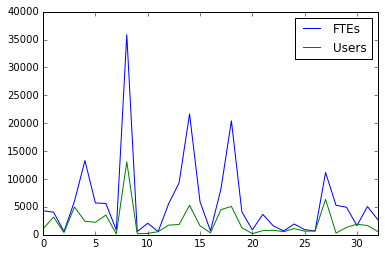

In [117]:
%matplotlib inline
ftes.plot()

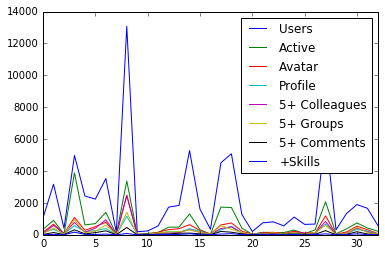

In [118]:
users.plot()

In [ ]:
# Save files for analysis and graphing

mainframe.to_csv(os.path.join(output_path, 'gcconnex_individual_stats-{}.csv'.format(
        dt.date.today())))

department_stats.to_csv(os.path.join(output_path, 'gcconnex_department_stats-{}.csv'.format(
        dt.date.today())))

cioc_stats.to_csv(os.path.join(output_path, 'gcconnex_cioc_stats-{}.csv'.format(
        dt.date.today())))

ftes.to_csv(os.path.join(output_path, 'gcconnex_fte_stats-{}.csv'.format(
        dt.date.today())))

users.to_csv(os.path.join(output_path, 'gcconnex_user_stats-{}.csv'.format(
        dt.date.today())))


## Graphing the data

In [ ]:
# Basic Seaborn Chart

sns_plot = sns.barplot(palette='muted', units="Users",
    data=department_stats.loc[department_stats.Department == 'CANADA'])

sns_plot.set_title('CANADA')

fig = sns_plot.get_figure()

fig.savefig('Canada.png')

In [ ]:
# Print all departmental graphs for User Info

sns.set_context('poster')

for dept in users.Department:
    
    sns_plot = sns.barplot(palette='muted',
        data=users.loc[users.Department == dept])
    
    sns_plot.set_title(dept)

    fig = sns_plot.get_figure()
    
    dept_title = dept.split('/')[0]

    fig.savefig(os.path.join(output_path, 'department_graphs',
                             '{}_users_2016.png'.format(dept_title)))
    
    plt.close()

In [ ]:
# Print all departmental graphs for FTE Info

sns.set_context('poster')

for dept in ftes.Department:
    
    sns_plot = sns.barplot(palette='muted',
        data=ftes.loc[ftes.Department == dept])
    
    sns_plot.set_title(dept)

    fig = sns_plot.get_figure()
    
    dept_title = dept.split('/')[0]

    fig.savefig(os.path.join(output_path, 'department_graphs',
                             '{}_ftes_2016.png'.format(dept_title)))
    
    plt.close()

## Network Graphing

In [119]:
n_users = user_df.transpose()

In [120]:
nu = n_users.to_dict()

In [121]:
nu[0]

{'Created': '2008-12-15',
 'Department': 'PWGSC/TPSGC',
 'Last_login': '2009-08-24',
 'Name': '3e0e56955b8cbcb43249586734c5a4907583dc20',
 'User': 4}

In [122]:
colleagues[0]

(6, 7, '1969-12-31')

In [123]:
import networkx as nx

In [124]:
G = nx.DiGraph()

In [125]:
for user in nu:
    data = nu[user]
    G.add_node(data['User'], name=data['Name'],
               department=data['Department'], 
               created=data['Created'])

In [126]:
for edge in colleagues:
    user, friend, connected = edge
    
    G.add_edge(user, friend, date=connected)

In [127]:
nx.write_gexf(
    G, os.path.join(
        data_path, "gcconnex_users_content_{}.gexf".format(dt.date.today())))